In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
ratings = pd.read_csv("models/data/ml-1m/ratings.dat", sep='::', header=None, names=['userid', 'movieid', 'rating', 'ts'], engine='python', encoding='latin-1')
movies = pd.read_csv('models/data/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'movie_title', 'genres'], engine='python', encoding='latin-1')

In [4]:
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genre_dummies], axis=1)
movies.drop('genres', axis=1, inplace=True)

In [5]:
prop_rep = {}
for col in movies.columns:
    i = 0
    for row in movies[col]:
        if row == 1:
            i += 1
    prop_rep[col] = i

del prop_rep['movie_id']
del prop_rep['movie_title']

In [6]:
total_orig_genre = sum(prop_rep.values())

In [7]:
for key in prop_rep.keys():
    prop_rep[key] = prop_rep[key] / total_orig_genre

In [8]:
prop_rep

{'Action': 0.0784956304619226,
 'Adventure': 0.04416354556803995,
 'Animation': 0.01638576779026217,
 "Children's": 0.03916978776529338,
 'Comedy': 0.18726591760299627,
 'Crime': 0.03292759051186017,
 'Documentary': 0.019818976279650437,
 'Drama': 0.2501560549313358,
 'Fantasy': 0.010611735330836454,
 'Film-Noir': 0.00686641697877653,
 'Horror': 0.05352684144818976,
 'Musical': 0.017790262172284643,
 'Mystery': 0.016541822721598,
 'Romance': 0.07350187265917603,
 'Sci-Fi': 0.04307116104868914,
 'Thriller': 0.07677902621722846,
 'War': 0.02231585518102372,
 'Western': 0.010611735330836454}

In [9]:
# manually switch between to generate plots
predictions10 = np.load("models/predictions/poisson_predictions_10.npy")
predictions20 = np.load("models/predictions/poisson_predictions_20.npy")
predictions50 = np.load("models/predictions/poisson_predictions_50.npy")

In [10]:
top_50_movie_features = []

for user_predictions in predictions10:
    top_50_indices = np.argsort(user_predictions)[-50:][::-1]
    top_50_movie_ids = movies[movies['movie_id'].isin(top_50_indices)]
    top_50_features = []
    for col in top_50_movie_ids.columns:
        for row in top_50_movie_ids[col]:
            if row == 1:
                top_50_features.append(col)
    
    top_50_movie_features.append(top_50_features)

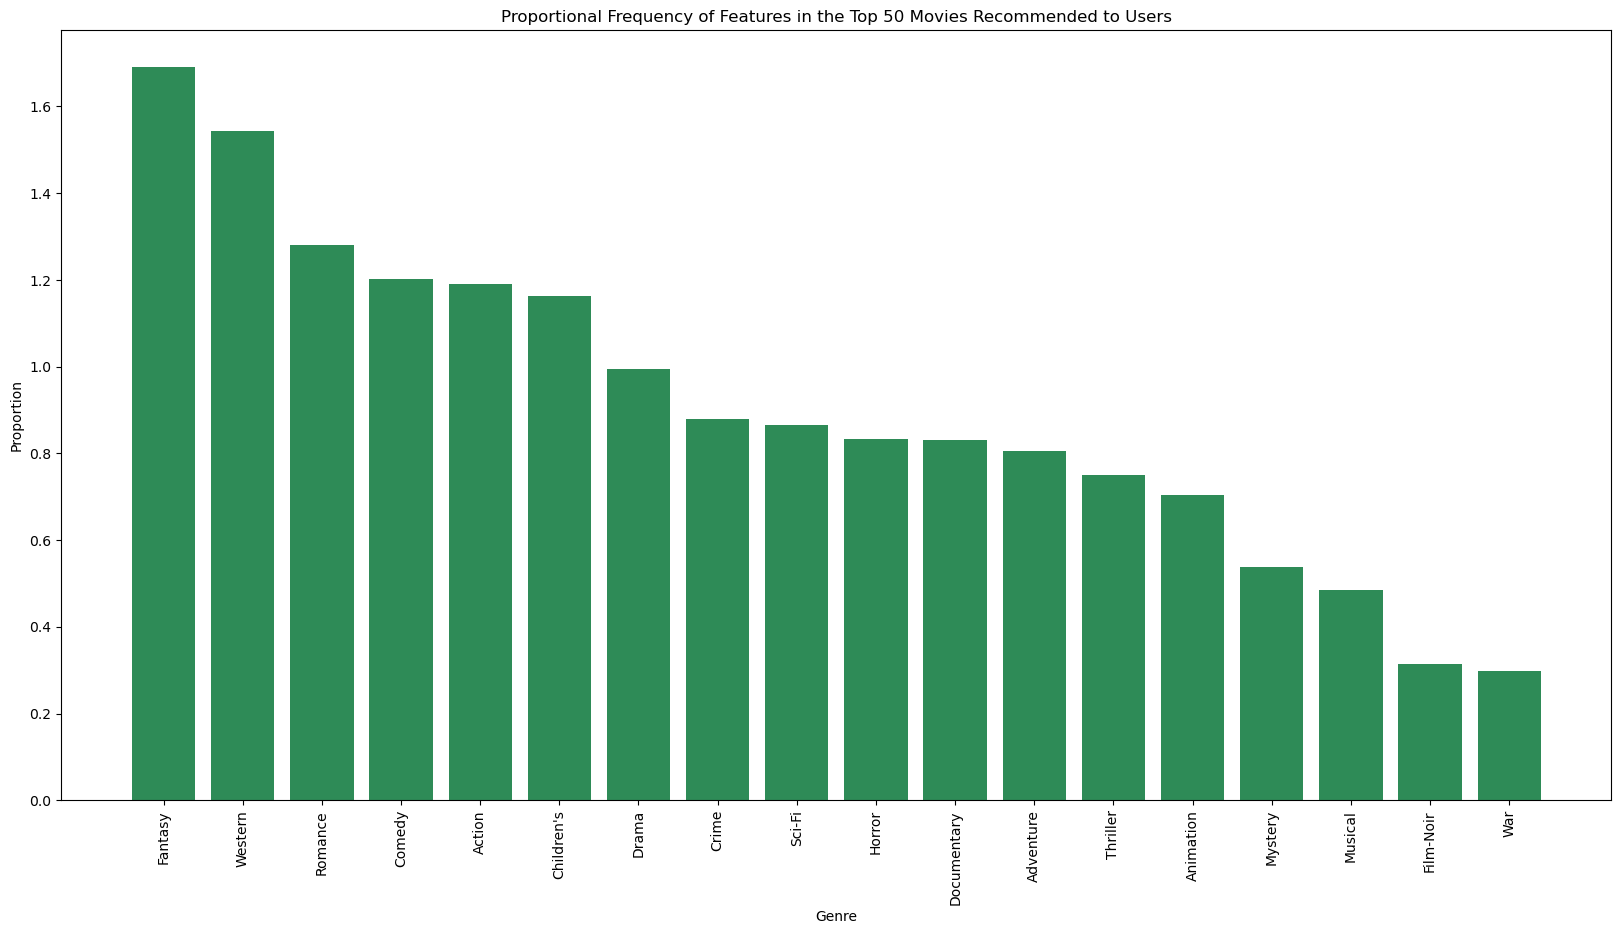

In [11]:
from collections import Counter

flat_list = [item for sublist in top_50_movie_features for item in sublist]

feature_counts = Counter(flat_list)

del feature_counts['movie_id']

norm_total = sum(feature_counts.values())
for key in feature_counts.keys():
    feature_counts[key] = feature_counts[key] / norm_total

for key in feature_counts.keys():
    feature_counts[key] = feature_counts[key] / prop_rep[key]


# Convert the feature counts to a dataframe
feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index').reset_index()
feature_counts_df.columns = ['Feature', 'Count']

# Sort the dataframe by the count
feature_counts_df = feature_counts_df.sort_values(by='Count', ascending=False)

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(feature_counts_df['Feature'], feature_counts_df['Count'], color='seagreen')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.title('Proportional Frequency of Features in the Top 50 Movies Recommended to Users')
plt.show()

In [12]:
feature_counts_df

,Feature,Count
7,Fantasy,1.691284
14,Western,1.543331
11,Romance,1.279652
3,Comedy,1.202714
0,Action,1.191692
2,Children's,1.162401
6,Drama,0.995416
4,Crime,0.879126
12,Sci-Fi,0.865829
8,Horror,0.833827


In [63]:
tested_users10 = np.load("models/predictions/poisson_test_users_10.npy")
tested_users20 = np.load("models/predictions/poisson_test_users_20.npy")
tested_users50 = np.load("models/predictions/poisson_test_users_50.npy")

In [ ]:
# filter user_data by users in tested_users
filtered_user_data = ratings[ratings['userid'].isin(tested_users50)]

In [65]:
# make dictionary with movie IDs and counts
movie_counts = filtered_user_data['movieid'].value_counts().to_dict()

In [66]:
len(movie_counts)

3706

In [ ]:
# re-run and explicity calculate the difference between medians
# top 20%

In [67]:
from operator import itemgetter
res = dict(sorted(movie_counts.items(), key=itemgetter(1), reverse=True)[:800])

In [68]:
popular_items = res.keys()

In [ ]:
# for each user, count the number of popular movies they have rated
popular_movie_counts = {}
for user in tested_users50:
    user_data = filtered_user_data[filtered_user_data['userid'] == user]
    popular_movie_count = user_data[user_data['movieid'].isin(popular_items)].shape[0]
    popular_movie_counts[user] = popular_movie_count

In [ ]:
#for each user, count the total number of movies they have rated
total_movie_counts = {}
for user in tested_users50:
    user_data = filtered_user_data[filtered_user_data['userid'] == user]
    total_movie_count = user_data.shape[0]
    total_movie_counts[user] = total_movie_count

In [ ]:
#make a dictionary with the proportion of popular/total for each user
prop_popular = {}
for user in tested_users50:
    prop_popular[user] = popular_movie_counts[user] / total_movie_counts[user]

In [72]:
prop_popular = {key: value for key, value in prop_popular.items() if value != 0}

In [73]:
max(prop_popular.values())

0.9583333333333334

In [74]:
top_50_movie_pop = []

for user_predictions in predictions10:
    # Get the indices of the top 50 highest rated predictions
    top_50_indices = np.argsort(user_predictions)[-50:][::-1]
    
    # Get the movie IDs for these indices
    top_50_movie_ids = movies[movies['movie_id'].isin(top_50_indices)]
    count_pop = 0
    for row in top_50_movie_ids["movie_id"]:
        if row in popular_items:
            count_pop += 1
    
    top_50_pop = count_pop / 50
    top_50_movie_pop.append(top_50_pop)

In [75]:
max(top_50_movie_pop)

0.2

In [76]:
# what was this for?
#i = 0
#for user in prop_popular:
#    prop_popular[user] = top_50_movie_pop[i] / prop_popular[user]
#    i += 1

In [77]:
so = prop_popular.values()
soso = list(so)

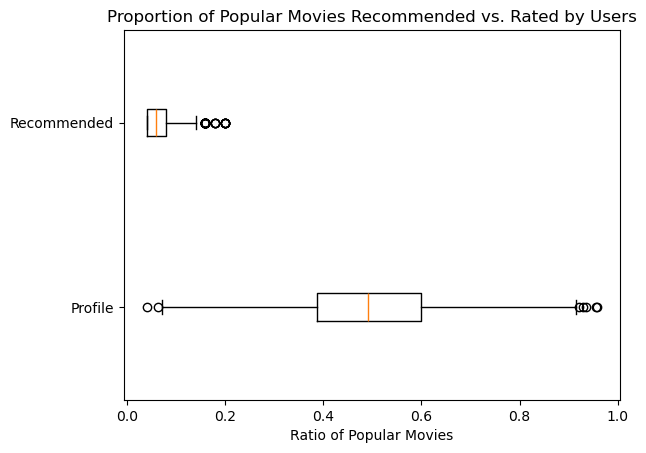

In [78]:
# scatterplot prop_popular
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot([soso, top_50_movie_pop], labels=["Profile", "Recommended"], vert=False)
plt.xlabel('Ratio of Popular Movies')
plt.title('Proportion of Popular Movies Recommended vs. Rated by Users')
plt.show()